In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

# parameters
e_mass = 5.48579909-4     # electron mass in amu
t0 = 315775               # a.u. to K
tau0 = 2.418884326509e-17 # a.u. to sec
 
#  universal truths, in SI units
kB = 1.3806e-23
hbar = 1.05457e-34
AMU = 1.6605e-27
Hartree = 4.359744e-18
auLength = 5.29177e-11

In [3]:
# define properties of molecules
reduced_masses = {"NaKNaK" : 62 / 2, "RbKRb" : 87 * (87 + 40) / (87 + 87 + 40)}     # amu
van_der_wall_coeffs = {"NaKNaK" : 561070, "RbKRb" : 8000}      # a.u.

molecules = "NaKNaK"
mu = reduced_masses[molecules] / e_mass      # now in a.u.
c6 = van_der_wall_coeffs[molecules]          # a.u.

# define natural units
beta = (2 * mu * c6) ** (1/4)    # length 
E_beta = 1 / (2 * mu * beta ** 2)   # energy
tau_beta = 2 * np.pi / E_beta    # time
print("beta (a0)", beta)
print("E_beta (K)", E_beta * t0)
print("tau_beta (s)", tau_beta * tau0)

abar = (np.pi * 2 ** (-3/2) / math.gamma(5/4) / math.gamma(1.2)) ** 2

beta (a0) 69.56041467855822
E_beta (K) 1.563946230456178
tau_beta (s) 3.068674998394627e-11


In [27]:
num_samples = 500

# properties of resonant spectrum
mean_spacing = 10.0
mean_x = 0.1
num_resonances = 401       # should be odd
mean_coupling_strength = np.sqrt(mean_x * mean_spacing / np.pi ** 2)

# thermal properties
threshold_energy = 0.1
temp = 0.5
num_energies = 2000

In [48]:
def generate_spectrum(num_resonances, mean_spacing, mean_coupling_strength, num_open_channels = 1):
    # assert(num_resonances % 2 == 1)
    # midpoint = num_resonances // 2
    # energy_max = num_resonances / 2 * mean_spacing
    # energy_min = -energy_max
    
    # rng
    rng = np.random.default_rng()

    uniform_dist = rng.uniform(0, 1, num_resonances - 1)
    # transform uniform into a Wigner-Dyson distribution
    nearest_neighbor = mean_spacing * np.sqrt(-4 / np.pi * np.log(1 - uniform_dist))

    # generate energies
    energy_GOE_mat = np.zeros(num_resonances)
    energy_GOE_mat[0] = -np.sum(nearest_neighbor) / 2
    for i in range(num_resonances - 1):
        energy_GOE_mat[i + 1] = energy_GOE_mat[i] + nearest_neighbor[i]
    
    for i in range(num_resonances):
        if energy_GOE_mat[i] == 0:
            print("mayday")

    # generate coupling matrix
    W_mat = np.zeros(num_resonances)
    for mu in range(num_resonances):
        W_mat[mu] = rng.normal(0, mean_coupling_strength)

    # find effective hamiltonian
    # Heff = energy_GOE_mat - 1j * np.pi * (W_mat @ W_mat.T) 

    # actual coupling constant
    x_actual = np.pi ** 2 / mean_spacing * np.var(W_mat)

    return energy_GOE_mat, W_mat, x_actual

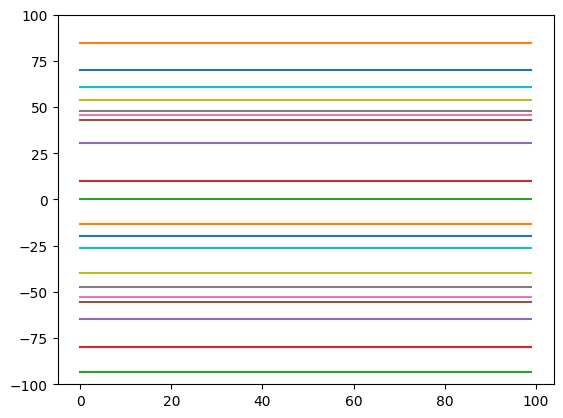

0.1 0.09600750723708616


In [6]:
H_goe, W_mat, x_actual = generate_spectrum(num_resonances, mean_spacing, mean_coupling_strength)

for i in range(num_resonances):
    plt.plot([j for j in range(100)], [H_goe[i, i] for j in range(100)])
plt.ylim([-100, 100])
plt.show()

print(np.pi ** 2 / mean_spacing * mean_coupling_strength ** 2, x_actual)

In [46]:
def wigner_smith_matrix(collision_energy, H_goe, W_squared):
    # values for calculation
    k = np.sqrt(collision_energy)
    A_mqdt = abar * k
    A_prime = abar / 2 / k
    G_mqdt = (1 / 3 - abar ** 2) * np.square(k)
    G_prime = (1 / 3 - abar ** 2)
    eta_mqdt = -abar * k
    eta_prime = -abar / 2 / k 

    collision_energy = np.reshape(collision_energy, (len(collision_energy), 1))
    energy_diff = collision_energy - H_goe
    ratio = W_squared / energy_diff

    Y_mat = -np.pi * np.sum(ratio, axis=1)
    Y_prime = np.pi * np.sum(ratio / energy_diff, axis=1)

    K_mat = A_mqdt * Y_mat / (1 + G_mqdt * Y_mat)
    K_prime = (A_prime * Y_mat + A_mqdt * Y_prime) / (1 + G_mqdt * Y_mat) - A_mqdt * Y_mat * (G_prime * Y_mat + G_mqdt * Y_prime) / (1 + G_mqdt * Y_mat) ** 2

    Q_mat = 2 * (eta_prime + K_prime / (1 + K_mat ** 2))
        
    return Q_mat

In [45]:
def relative_MB_weights(temp, energy):
    beta = 1 / temp
    weight = 2 * beta ** (3/2) * np.sqrt(energy / np.pi) * np.exp(-beta * energy)
    return weight

def thermal_time_delay(temp, energy_GOE_mat, W_mat, num_energies):
    energy_grid = np.linspace(0.001, 10 * temp, num=num_energies)
    grid_spacing = energy_grid[1] - energy_grid[0]

    relative_time_delay = grid_spacing * relative_MB_weights(temp, energy_grid) * wigner_smith_matrix(energy_grid, energy_GOE_mat, np.square(W_mat))

    return np.sum(relative_time_delay)
    

(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)
(401,)
(2000, 401)


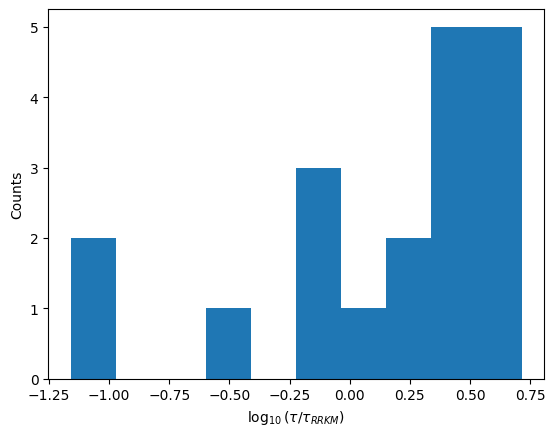

In [50]:
time_delays = []
for i in range(100):
    energy_GOE_mat, W_mat, x_actual = generate_spectrum(num_resonances, mean_spacing, mean_coupling_strength)
    time_delay = thermal_time_delay(temp, energy_GOE_mat, W_mat, num_energies)
    time_delays.append(time_delay)

positive = [delay for delay in time_delays if delay > 0]
frac_positive = len(positive) / len(time_delays) 
print("Fraction Positive: ", frac_positive)

normalized = (mean_spacing / 2 / np.pi) * np.array(positive)
mean_delay = np.mean(normalized)
std_delay = np.std(normalized)

log_delay = np.log10(normalized)
plt.hist(log_delay, bins=10)
plt.xlabel(f"$\\log_{{10}} (\\tau / \\tau_{{RRKM}})$")
plt.ylabel("Counts")
plt.show()

